<a href="https://colab.research.google.com/github/oopere/GANs/blob/main/C4_COND_GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4 - GAN Tutorial.
## Generate Mnist Images with a CONDITIONAL DCGAN.

In [3]:
#!pip install tensorflow==2.9.0
import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
import matplotlib.pyplot as plt
from IPython import display


print (tf.__version__)

2.16.1


In [4]:
def plot_results(images, n_cols=None):
    '''visualizes fake images'''
    #display.clear_output(wait=False)  

    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    plt.figure(figsize=(n_cols, n_rows))
    
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap = "binary")
        plt.axis("off")
    plt.show()

In [5]:
def load_dataset():
  # download the training images
  (X_train, y_train), (_, _) = keras.datasets.mnist.load_data()

  # normalize pixel values
  X_train = X_train.astype(np.float32) / 255

  # reshape and rescale
  X_train = X_train.reshape(-1, 28, 28, 1) * 2. - 1.

  return [X_train, y_train]

In [6]:
def get_dataset_samples(dataset, n_samples):
  images, labels = dataset

  ix = np.random.randint(0, images.shape[0], n_samples)

  X, labels = images[ix], labels[ix]

  y = np.ones((n_samples, 1))
  return [X, labels], y

In [7]:
def generate_noise(noise_size, n_samples, n_classes=10):
  #generate noise
  x_input = np.random.randn(noise_size * n_samples)
  
  #shape to adjust to batch size
  z_input = x_input.reshape(n_samples, noise_size)

  #generate labels
  labels = np.random.randint(0, n_classes, n_samples)
  return [z_input, labels]



In [8]:
def generate_fake_samples(generator, latent_dim, n_samples): 
  #get the noise calling the function
  z_input, labels_input = generate_noise(latent_dim, n_samples)

  images = generator.predict([z_input, labels_input])

  #create class labes
  y = np.zeros((n_samples, 1))
  return [images, labels_input], y


In [9]:
# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
  # label input
  in_label = keras.layers.Input(shape=(1,))
  # embedding for categorical input
  li = keras.layers.Embedding(n_classes, 50)(in_label)
  # linear multiplication
  n_nodes = 7 * 7
  li = keras.layers.Dense(n_nodes)(li)
  # reshape to additional channel
  li = keras.layers.Reshape((7, 7, 1))(li)
  # image generator input
  in_lat = keras.layers.Input(shape=(latent_dim,))
  # foundation for 7x7 image
  n_nodes = 128 * 7 * 7
  gen = keras.layers.Dense(n_nodes)(in_lat)

  gen = keras.layers.LeakyReLU(alpha=0.2)(gen)
  gen = keras.layers.Reshape((7, 7, 128))(gen)
  # merge image gen and label input
  merge = keras.layers.Concatenate()([gen, li])
  # upsample to 14x14
  gen = keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', 
                                     activation=keras.layers.LeakyReLU(alpha=0.2))(merge)
  gen = keras.layers.BatchNormalization()(gen)
  # upsample to 28x28
  gen = keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', 
                                     activation=keras.layers.LeakyReLU(alpha=0.2))(gen)
  gen = keras.layers.BatchNormalization()(gen)
  # output
  out_layer = keras.layers.Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
  # define model
  model = keras.Model([in_lat, in_label], out_layer)
  return model

In [10]:
noise_size = 50

generator = define_generator(noise_size)

generator.summary()

C:\Users\fisch\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 6272)      │    319,872 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 50)     │        500 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 6272)      │          0 │ dense_1[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 49)     │      2,499 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 7, 7, 128) │          0 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 7, 7, 1)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 7, 7, 129) │          0 │ reshape_1[0][0],  │
│ (Concatenate)       │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 14, 14,    │    264,320 │ concatenate[0][0] │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 14, 14,    │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 28, 28,    │    262,272 │ batch_normalizat… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28, 1) │      6,273 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 856,760 (3.27 MB)

 Trainable params: 856,248 (3.27 MB)

 Non-trainable params: 512 (2.00 KB)

In [11]:
def define_discriminator(in_shape=(28, 28, 1), n_classes=10):
  in_label = keras.layers.Input(shape=(1,))
  li = keras.layers.Embedding(n_classes, 50)(in_label)

  n_nodes = in_shape[0] * in_shape[1]
  li=keras.layers.Dense(n_nodes)(li)

  li=keras.layers.Reshape((in_shape[0], in_shape[1], 1))(li)

  in_image = keras.layers.Input(shape=in_shape)

  merge = keras.layers.Concatenate()([in_image, li])

  #downsample
  fe=keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', 
                         activation=keras.layers.LeakyReLU(alpha=0.2))(merge)
  fe=keras.layers.Dropout(0.4)(fe)

  #downsample
  fe=keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', 
                         activation=keras.layers.LeakyReLU(alpha=0.2))(fe)
  fe=keras.layers.Dropout(0.4)(fe)

  fe = keras.layers.Flatten()(fe)

  out_layer = keras.layers.Dense(1, activation='sigmoid')(fe)

  model = keras.Model([in_image, in_label], out_layer)

  opt = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

  return model

                              

In [12]:
discriminator = define_discriminator()
discriminator.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 50)     │        500 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1, 784)    │     39,984 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 28, 28, 1) │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 28, 28, 2) │          0 │ input_layer_3[0]… │
│ (Concatenate)       │                   │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 14, 14,    │      2,432 │ concatenate_1[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 14, 14,    │          0 │ conv2d_1[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 7, 7, 128) │    147,584 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 7, 7, 128) │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 6272)      │          0 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      6,273 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 196,773 (768.64 KB)

 Trainable params: 196,773 (768.64 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
#define the Conditional GAN
def define_gan(generator, discriminator):
  #make discriminator non trainable
  discriminator.trainable = False
  #get noise and label from generator
  gen_noise, gen_label = generator.input
  #get output from generator
  gen_output = generator.output

  #connect image and label input from generator as inputs to discriminator
  gan_output = discriminator([gen_output, gen_label])

  #define the GAN model. 
  model= keras.Model([gen_noise, gen_label], gan_output)

  #compile model
  opt = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model


In [14]:
GAN = define_gan(generator, discriminator)

In [15]:
GAN.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 6272)      │    319,872 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 50)     │        500 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 6272)      │          0 │ dense_1[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 49)     │      2,499 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 7, 7, 128) │          0 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 7, 7, 1)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 7, 7, 129) │          0 │ reshape_1[0][0],  │
│ (Concatenate)       │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 14, 14,    │    264,320 │ concatenate[0][0] │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 14, 14,    │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 28, 28,    │    262,272 │ batch_normalizat… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28, 1) │      6,273 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, 1)         │    196,773 │ conv2d[0][0],     │
│ (Functional)        │                   │            │ input_layer[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,053,533 (4.02 MB)

 Trainable params: 856,248 (3.27 MB)

 Non-trainable params: 197,285 (770.64 KB)

In [16]:
tf.keras.backend.clear_session()

In [33]:
def train_gan(generator, discriminator, GAN, dataset, noise_size=100, n_epochs=30, n_batch=512):
  steps = int(dataset[0].shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for e in range(n_epochs):
    # enumerate batches over the training set
    for s in range(steps):
      #TRAIN THE DISCRIMINATOR
      # get randomly selected 'real' samples
      [X_real, labels_real], y_real = get_dataset_samples(dataset, half_batch)
      # update discriminator model weights
      d_loss1, _ = discriminator.train_on_batch([X_real, labels_real], y_real)
      # generate 'fake' examples
      [X_fake, labels], y_fake = generate_fake_samples(generator, noise_size, half_batch)
      # update discriminator model weights
      d_loss2, _ = discriminator.train_on_batch([X_fake, labels], y_fake)

      #TRAIN THE GENERATOR
      # prepare points in latent space as input for the generator
      [z_input, labels_input] = generate_noise(noise_size, n_batch)
      # create inverted labels for the fake samples
      y_gan = np.ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = GAN.train_on_batch([z_input, labels_input], y_gan)
      g_loss_value = np.mean(g_loss)
      # summarize loss on this batch
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
      (e+1, s+1, steps, d_loss1, d_loss2, g_loss_value))
    # plot_results(X_fake, 8)  
    
  # save the generator model
  generator.save('cgan_generator.h5')


In [18]:

dataset = load_dataset()


In [34]:
train_gan(generator, discriminator, GAN, dataset, noise_size, n_epochs=30, n_batch=128)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
>1, 1/468, d1=0.683, d2=0.683 g=0.578
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
>1, 2/468, d1=0.683, d2=0.683 g=0.578
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
>1, 3/468, d1=0.683, d2=0.683 g=0.578
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
>1, 4/468, d1=0.683, d2=0.684 g=0.577
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
>1, 5/468, d1=0.683, d2=0.684 g=0.578
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
>1, 6/468, d1=0.683, d2=0.684 g=0.577
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
>1, 7/468, d1=0.683, d2=0.684 g=0.577
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
>1, 8/468, d1=0.683, d2=0.684 g=0.577
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
>1, 9/468, d1=0.684, d2=0.684 g=0.577
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>1, 10/468, d1=0.684, d2=0.684 g=0.577
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
>1, 11/468, d1=0.684, d2=0.684 g=0.577
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
>1, 12/468, d1=0.684, d2=0.684 g=0.578
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
>1, 13/468, d1=0.684, d2=0.684 g=0.578
2/2 ━━━━

KeyboardInterrupt: 

1/1 [==============================] - 0s 177ms/step


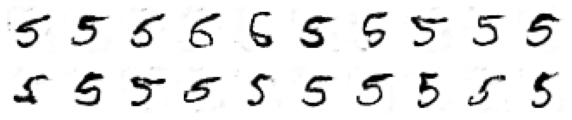

1/1 [==============================] - 0s 30ms/step


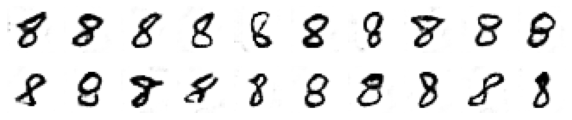

In [28]:
#Test de Conditional Generator. 
model = keras.models.load_model('cgan_generator.h5')

latent_points, labels = generate_noise(noise_size, 20)
labels = np.ones(20) * 3
X = model.predict([latent_points, labels])
plot_results(X, 10)

labels = np.ones(20) * 9
X = model.predict([latent_points, labels])
plot_results(X, 10)